In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="plsdbgfinalexps")
  con.set_session(readonly=True, autocommit=False)

In [2]:
exp_data_sql = """
SELECT 
	ex.exp_id,
  ex.attacker_rate,
  ex.proxy_connections,
	COUNT(e.message_marker)
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
lay_of_the_land

,exp_id,attacker_rate,proxy_connections,count
0,1client_0attacker_80secserver_2retry_reuse_90v...,100mbps,90,31775


In [3]:
experiments = [
  "'1attacker10mbps_1client_30vs100conns_8gb'",
  "'1attacker10mbps_1client_60vs100conns_8gb'",
  "'1attacker10mbps_1client_90vs100conns_8gb'",

  "'1attacker50mbps_1client_30vs100conns_8gb'",
  "'1attacker50mbps_1client_60vs100conns_8gb'",
  "'1attacker50mbps_1client_90vs100conns_8gb'",

  "'1attacker100mbps_1client_30vs100conns_8gb'",
  "'1attacker100mbps_1client_60vs100conns_8gb'",
  "'1attacker100mbps_1client_90vs100conns_8gb'",
]

len(experiments)

9

In [4]:
client_message_send_sql = """
SELECT 
	d.exp_id,
  ex.proxy_connections,
  ex.attacker_rate,
	COUNT({} e.message_marker) AS client_messages
FROM
	deployed_node d
  JOIN experiment ex ON ex.exp_id = d.exp_id
	JOIN event e ON d.dnid = e.observer_id
	JOIN node n ON n.node_id = d.node_id
	JOIN message m ON m.message_id = e.message_id
WHERE
	d.exp_id IN ({})
	AND n.node_name LIKE 'client%'
	AND m.{} = n.node_id
GROUP BY
	d.exp_id,
  ex.proxy_connections,
  ex.attacker_rate
;
"""

recv_sql = client_message_send_sql.format('', ",".join(experiments), 'dst_id')
df = pd.read_sql_query(recv_sql, con)
con.commit()

df = lay_of_the_land.merge(df, how='outer')
df.fillna(0, inplace=True)

df["attacker_rate"] = df["attacker_rate"].astype(str).str.rstrip("mbps").astype(int)
df.rename(columns={"attacker_rate": "attacker_rate_mbps"}, inplace=True)

df

,exp_id,attacker_rate_mbps,proxy_connections,count,client_messages
0,1client_0attacker_80secserver_2retry_reuse_90v...,100,90,31775,0


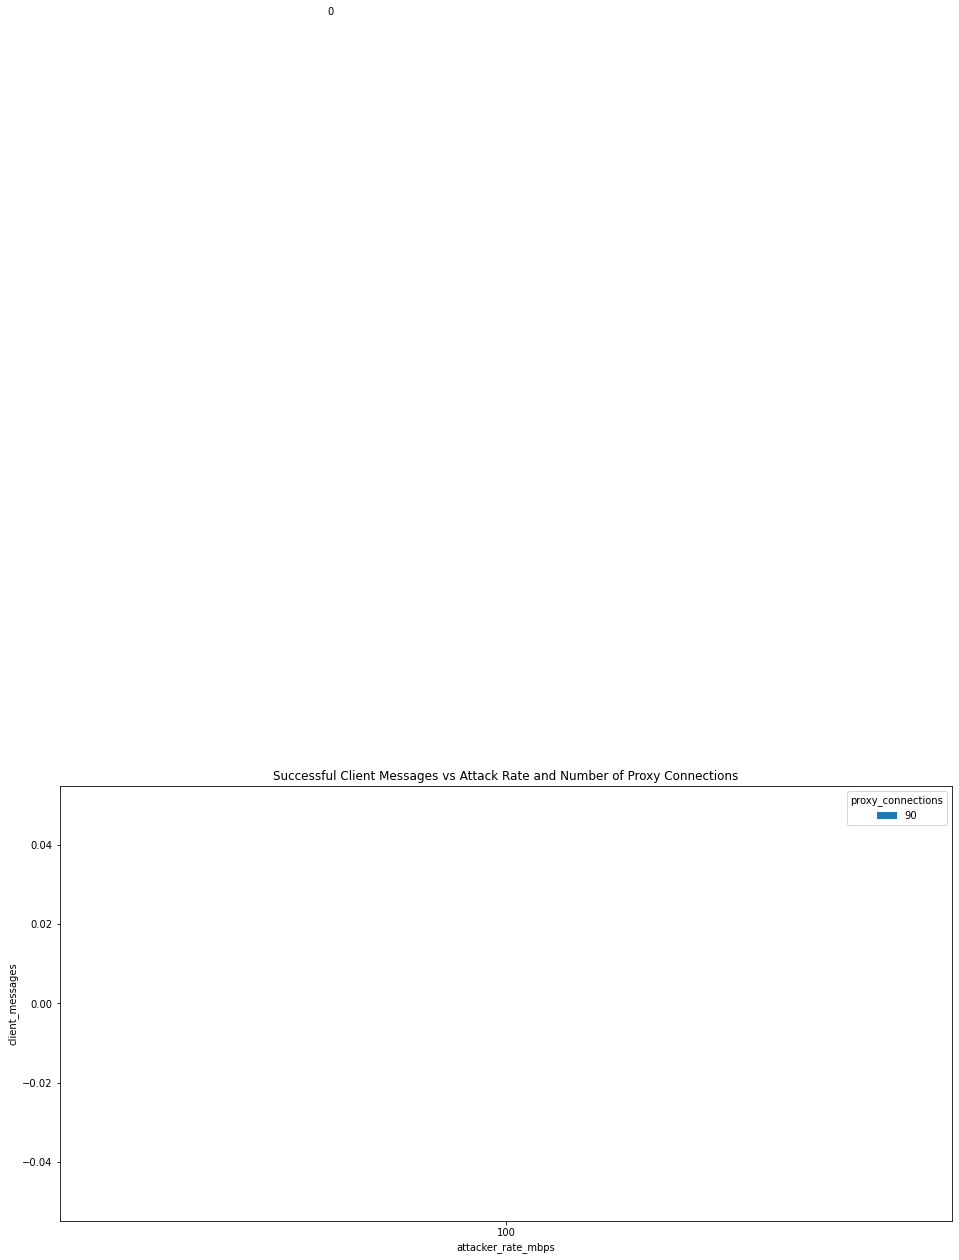

In [5]:
ndf = df.drop(columns=["exp_id", "count"])
ndf.sort_values(by=["attacker_rate_mbps", "proxy_connections"], inplace=True)

pndf = ndf.pivot(index="attacker_rate_mbps", columns="proxy_connections")
bars = pndf.plot.bar(
    y="client_messages",
    rot=0,
    ylabel="client_messages",
    title="Successful Client Messages vs Attack Rate and Number of Proxy Connections",
)
for rect in bars.patches:
  x, _ = rect.xy
  y = rect.get_height()
  plt.text(x+0.05, y+0.25, y)